In [1]:
# First let's verify the path and check available models
import os
from pathlib import Path

# Print all model files in the directory
model_dir = "saved_models"
print("Available models:")
for file in os.listdir(model_dir):
    if file.endswith('.pt'):
        print(file)


Available models:
model_epoch_10.pt
model_epoch_15.pt
model_epoch_20.pt
model_epoch_25.pt
model_epoch_30.pt
model_epoch_35.pt
model_epoch_40.pt
model_epoch_45.pt
model_epoch_5.pt
model_epoch_50.pt


C:\ANACONDA3\Lib\site-packages\albumentations\__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
C:\Users\BRIJESH KUMAR GHADEI\AppData\Local\Temp\ipykernel_21668\3000596434.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlis

Using device: cpu
Saved segmentation result to: C:\Users\BRIJESH KUMAR GHADEI\Downloads\segmented_Untitled Project (2).jpg


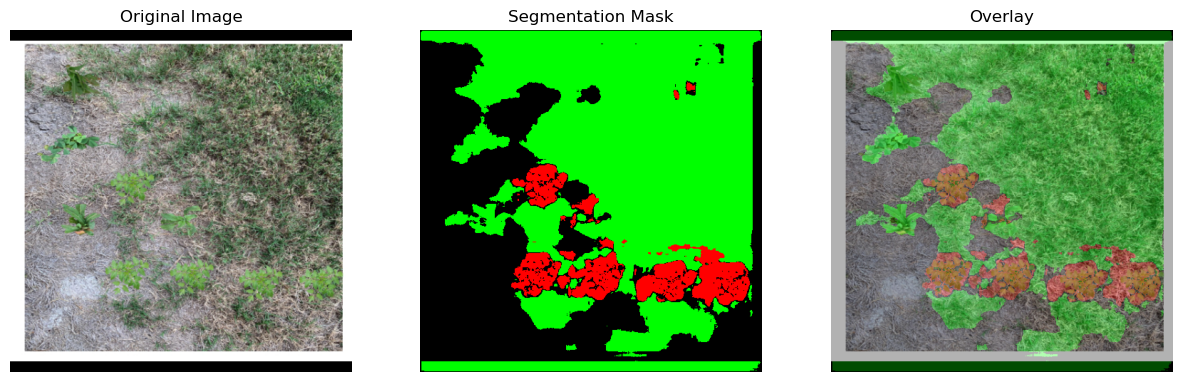

In [3]:
import torch
import torch.nn as nn
import cv2
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
from pathlib import Path

class LightweightUNet(nn.Module):
    def __init__(self, n_classes=3):
        super(LightweightUNet, self).__init__()
        
        # Encoder
        self.enc1 = self._conv_block(3, 32)
        self.enc2 = self._conv_block(32, 64)
        self.enc3 = self._conv_block(64, 128)
        self.enc4 = self._conv_block(128, 256)
        
        # Decoder
        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec3 = self._conv_block(256, 128)
        
        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec2 = self._conv_block(128, 64)
        
        self.up1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec1 = self._conv_block(64, 32)
        
        self.final = nn.Conv2d(32, n_classes, kernel_size=1)
        self.max_pool = nn.MaxPool2d(2)
        
    def _conv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        p1 = self.max_pool(e1)
        
        e2 = self.enc2(p1)
        p2 = self.max_pool(e2)
        
        e3 = self.enc3(p2)
        p3 = self.max_pool(e3)
        
        # Bridge
        e4 = self.enc4(p3)
        
        # Decoder
        d3 = self.up3(e4)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)
        
        d2 = self.up2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)
        
        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)
        
        return self.final(d1)

def preprocess_image(image_path, target_size=(480, 480)):
    """Preprocess image to fixed size while maintaining aspect ratio"""
    # Read image
    image = cv2.imread(str(image_path))
    if image is None:
        raise ValueError(f"Could not read image at {image_path}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Calculate resize dimensions while maintaining aspect ratio
    h, w = image.shape[:2]
    scale = min(target_size[0]/h, target_size[1]/w)
    new_h, new_w = int(h * scale), int(w * scale)
    
    # Resize image
    image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_AREA)
    
    # Create blank canvas of target size
    canvas = np.zeros((target_size[0], target_size[1], 3), dtype=np.uint8)
    
    # Calculate padding
    y_offset = (target_size[0] - new_h) // 2
    x_offset = (target_size[1] - new_w) // 2
    
    # Place image in center of canvas
    canvas[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = image
    
    return canvas, (y_offset, x_offset, new_h, new_w)

def segment_image(image_path, model_path):
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Load model
    model = LightweightUNet(n_classes=3).to(device)
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    # Preprocess image
    image, padding_info = preprocess_image(image_path)
    y_offset, x_offset, new_h, new_w = padding_info
    
    # Define transform
    transform = A.Compose([
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])
    
    # Transform image
    transformed = transform(image=image)
    image_tensor = transformed['image'].unsqueeze(0).to(device)
    
    # Get prediction
    with torch.no_grad():
        output = model(image_tensor)
        output = torch.sigmoid(output)
        pred_mask = output.squeeze().cpu().numpy()
    
    # Create visualization
    colors = [
        [0, 0, 0],      # Background (black)
        [0, 255, 0],    # Plant (green)
        [255, 0, 0]     # Weed (red)
    ]
    
    colored_mask = np.zeros((*pred_mask.shape[1:], 3), dtype=np.uint8)
    for i, color in enumerate(colors):
        colored_mask[pred_mask[i] > 0.5] = color
    
    # Extract the actual prediction area (remove padding)
    if y_offset > 0 and x_offset > 0:
        colored_mask = colored_mask[y_offset:y_offset+new_h, x_offset:x_offset+new_w]
        image = image[y_offset:y_offset+new_h, x_offset:x_offset+new_w]
    
    # Create visualization
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(colored_mask)
    plt.title('Segmentation Mask')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    overlay = cv2.addWeighted(image, 0.7, colored_mask, 0.3, 0)
    plt.imshow(overlay)
    plt.title('Overlay')
    plt.axis('off')
    
    # Save results
    output_path = Path(image_path).parent / f"segmented_{Path(image_path).name}"
    plt.savefig(output_path)
    print(f"Saved segmentation result to: {output_path}")
    plt.show()

if __name__ == "__main__":
    # Specify your model path and image path here
    MODEL_PATH = "saved_models/model_epoch_50.pt"  # Change this to your model path
    IMAGE_PATH = r"C:\Users\BRIJESH KUMAR GHADEI\Downloads\Untitled Project (2).jpg"
    
    segment_image(IMAGE_PATH, MODEL_PATH)

Using device: cpu


C:\Users\BRIJESH KUMAR GHADEI\AppData\Local\Temp\ipykernel_21668\2762627564.py:112: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_loc

Saved segmentation result to: C:\Users\BRIJESH KUMAR GHADEI\Downloads\segmented_bbox_Untitled Project (2).jpg


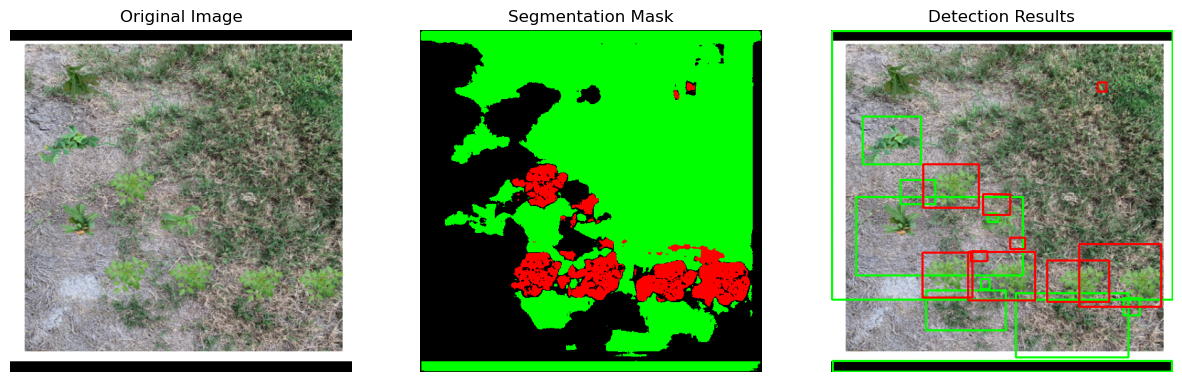

Found 10 crops and 9 weeds


In [5]:
import torch
import torch.nn as nn
import cv2
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
from pathlib import Path

# [Previous LightweightUNet class and preprocess_image function remain unchanged]
class LightweightUNet(nn.Module):
    def __init__(self, n_classes=3):
        super(LightweightUNet, self).__init__()
        
        # Encoder
        self.enc1 = self._conv_block(3, 32)
        self.enc2 = self._conv_block(32, 64)
        self.enc3 = self._conv_block(64, 128)
        self.enc4 = self._conv_block(128, 256)
        
        # Decoder
        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec3 = self._conv_block(256, 128)
        
        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec2 = self._conv_block(128, 64)
        
        self.up1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec1 = self._conv_block(64, 32)
        
        self.final = nn.Conv2d(32, n_classes, kernel_size=1)
        self.max_pool = nn.MaxPool2d(2)
        
    def _conv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        # [Previous forward method remains unchanged]
        # Encoder
        e1 = self.enc1(x)
        p1 = self.max_pool(e1)
        
        e2 = self.enc2(p1)
        p2 = self.max_pool(e2)
        
        e3 = self.enc3(p2)
        p3 = self.max_pool(e3)
        
        # Bridge
        e4 = self.enc4(p3)
        
        # Decoder
        d3 = self.up3(e4)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)
        
        d2 = self.up2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)
        
        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)
        
        return self.final(d1)

def get_bounding_boxes(mask, min_area=100):
    """
    Get bounding boxes for connected components in binary mask
    Returns: List of (x, y, w, h) bounding boxes
    """
    # Convert to binary
    binary = (mask > 0.5).astype(np.uint8)
    
    # Find connected components
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary)
    
    # Filter out small components and background (label 0)
    boxes = []
    for i in range(1, num_labels):  # Skip background label
        area = stats[i, cv2.CC_STAT_AREA]
        if area >= min_area:
            x = stats[i, cv2.CC_STAT_LEFT]
            y = stats[i, cv2.CC_STAT_TOP]
            w = stats[i, cv2.CC_STAT_WIDTH]
            h = stats[i, cv2.CC_STAT_HEIGHT]
            boxes.append((x, y, w, h))
    
    return boxes

def draw_boxes(image, boxes, color):
    """Draw bounding boxes on image"""
    img_with_boxes = image.copy()
    for (x, y, w, h) in boxes:
        cv2.rectangle(img_with_boxes, (x, y), (x + w, y + h), color, 2)
    return img_with_boxes

def segment_image(image_path, model_path):
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Load model
    model = LightweightUNet(n_classes=3).to(device)
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    # Preprocess image
    image, padding_info = preprocess_image(image_path)
    y_offset, x_offset, new_h, new_w = padding_info
    
    # Define transform
    transform = A.Compose([
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])
    
    # Transform image
    transformed = transform(image=image)
    image_tensor = transformed['image'].unsqueeze(0).to(device)
    
    # Get prediction
    with torch.no_grad():
        output = model(image_tensor)
        output = torch.sigmoid(output)
        pred_mask = output.squeeze().cpu().numpy()
    
    # Create visualization
    colors = [
        [0, 0, 0],      # Background (black)
        [0, 255, 0],    # Plant (green)
        [255, 0, 0]     # Weed (red)
    ]
    
    colored_mask = np.zeros((*pred_mask.shape[1:], 3), dtype=np.uint8)
    for i, color in enumerate(colors):
        colored_mask[pred_mask[i] > 0.5] = color
    
    # Extract the actual prediction area (remove padding)
    if y_offset > 0 and x_offset > 0:
        colored_mask = colored_mask[y_offset:y_offset+new_h, x_offset:x_offset+new_w]
        image = image[y_offset:y_offset+new_h, x_offset:x_offset+new_w]
    
    # Get bounding boxes for crops (green channel) and weeds (red channel)
    crop_boxes = get_bounding_boxes(pred_mask[1])  # Plant class
    weed_boxes = get_bounding_boxes(pred_mask[2])  # Weed class
    
    # Draw boxes on original image
    result_image = image.copy()
    result_image = draw_boxes(result_image, crop_boxes, (0, 255, 0))  # Green boxes for crops
    result_image = draw_boxes(result_image, weed_boxes, (255, 0, 0))  # Red boxes for weeds
    
    # Create visualization
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(colored_mask)
    plt.title('Segmentation Mask')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(result_image)
    plt.title('Detection Results')
    plt.axis('off')
    
    # Save results
    output_path = Path(image_path).parent / f"segmented_bbox_{Path(image_path).name}"
    plt.savefig(output_path)
    print(f"Saved segmentation result to: {output_path}")
    plt.show()
    
    # Print statistics
    print(f"Found {len(crop_boxes)} crops and {len(weed_boxes)} weeds")

if __name__ == "__main__":
    # Specify your model path and image path here
    MODEL_PATH = "saved_models/model_epoch_50.pt"  # Change this to your model path
    IMAGE_PATH = r"C:\Users\BRIJESH KUMAR GHADEI\Downloads\Untitled Project (2).jpg"
    
    segment_image(IMAGE_PATH, MODEL_PATH)